# Landuse machine learning model -test-

This notebook integrates the first steps towards the development of a machine learning model for urban landuse prediction.

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import aup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA



from keras import utils                                   # tools for creating one-hot encoding
from keras.models import Sequential                       # Type of model we wish to use
from keras.layers import Dense, Dropout, Activation  
from sklearn.preprocessing import LabelEncoder
# from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras import utils  
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
# from sklearn.pipeline import Pipeline

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,confusion_matrix

2025-07-17 12:34:12.359099: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-17 12:34:12.365486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752777252.372454   96672 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752777252.374607   96672 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752777252.380253   96672 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Data for model training

In [2]:
gdf = gpd.read_file('../../data/processed/prediccion_uso_suelo/test/area_of_prediction_prox.gpkg')
print(gdf.shape)
gdf.head(2)

(37061, 42)


,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,pobtot,...,denue_primaria_15min,denue_abarrotes,denue_abarrotes_15min,denue_peluqueria,denue_peluqueria_15min,denue_lavanderia,denue_lavanderia_15min,clues_primer_nivel,clues_primer_nivel_15min,geometry
0,Servicio,2257.817773,75GRMHR2+458V,1412000011206018,173.7348,278416.454431,2747.599834,0.009869,0.063231,0,...,0.0,7.696036,5.772197,8.017103,7.950595,8.005108,3.557762,16.196502,0.555897,"MULTIPOLYGON (((2349620.239 965525.905, 234961..."
1,Sin dato,711.098560,75GRMGRX+GQP3,1412000011206018,81.7922,278416.454431,900.765482,0.003235,0.090803,0,...,0.0,6.115355,3.994591,6.128543,6.752205,6.148625,2.126203,18.010403,0.042501,"MULTIPOLYGON (((2349506.214 965639.352, 234950..."


In [3]:
if 'fid' not in gdf.columns:
    gdf = gdf.reset_index().rename(columns={'index':'fid'})

In [4]:
gdf.columns

Index(['fid', 'uso_suelo', 'area_m2', 'full_plus_code', 'CVEGEO',
       'bld_area_m2', 'block_area_m2', 'pred_area_m2', 'pred_area_pct',
       'bld_pred_area_pct', 'pobtot', 'cultural_recreativo', 'servicios',
       'comercio', 'salud', 'educacion', 'gobierno', 'industria',
       'area_m2_tot', 'habitacional', 'uso_tot', 'pct_habitacional',
       'pct_cultural_recreativo', 'pct_servicios', 'pct_comercio', 'pct_salud',
       'pct_educacion', 'pct_gobierno', 'pct_industria',
       'temperature_mean_diff', 'ndvi_mean', 'ndmi_diff', 'denue_primaria',
       'denue_primaria_15min', 'denue_abarrotes', 'denue_abarrotes_15min',
       'denue_peluqueria', 'denue_peluqueria_15min', 'denue_lavanderia',
       'denue_lavanderia_15min', 'clues_primer_nivel',
       'clues_primer_nivel_15min', 'geometry'],
      dtype='object')

## Machine learning model

### Data preprocessing

#### PCA

In [5]:
cat_dict = {'edification':['area_m2','bld_area_m2','block_area_m2',
    'pred_area_m2', 'pred_area_pct', 'bld_pred_area_pct'],
           'landuse':['uso_tot','pobtot','pct_habitacional', 'pct_cultural_recreativo',
    'pct_servicios', 'pct_comercio', 'pct_salud', 'pct_educacion',
    'pct_gobierno', 'pct_industria'],
           'environment':['temperature_mean_diff','ndvi_mean','ndmi_diff'],
           'proximity':['denue_primaria', 'denue_primaria_15min',
    'denue_abarrotes', 'denue_abarrotes_15min', 'denue_peluqueria',
    'denue_peluqueria_15min', 'denue_lavanderia', 'denue_lavanderia_15min',
    'clues_primer_nivel', 'clues_primer_nivel_15min']}

Edification

In [6]:
category = 'edification'
pca_cat_cols = cat_dict[category]
gdf_category = gdf[pca_cat_cols].copy()

gdf_category[pca_cat_cols] = StandardScaler().fit_transform(np.array(gdf_category[pca_cat_cols]))
print(gdf_category.shape)
gdf_category.head(2)

(37061, 6)


,area_m2,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct
0,0.808572,0.453670,1.937134,0.892706,-0.395654,-0.342286
1,0.065991,-0.019517,1.937134,0.090725,-0.472954,-0.287216


In [7]:
num_comp = 4

pca = PCA(n_components=num_comp)

x = gdf_category.loc[:, pca_cat_cols].values

principalComponents = pca.fit_transform(x)

In [8]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.37276284 0.20153351 0.17243244 0.13192038] Explained variance: 0.8786491756444276


In [9]:
gdf_edif_pca = gdf[['fid']].copy()

for nc in range(num_comp):
    gdf_edif_pca.loc[:,[f'ed_pc_{nc+1}']] = np.nan
    gdf_edif_pca.loc[:,f'ed_pc_{nc+1}'] = principalComponents[:,nc].copy()

print(gdf_edif_pca.shape)
gdf_edif_pca.head(2)

(37061, 5)


,fid,ed_pc_1,ed_pc_2,ed_pc_3,ed_pc_4
0,0,1.676070,-1.43937,0.374140,0.489116
1,1,0.531907,-1.58021,0.359315,0.492876


Land use

In [10]:
category = 'landuse'
pca_cat_cols = cat_dict[category]
gdf_category = gdf[pca_cat_cols].copy()

gdf_category[pca_cat_cols] = StandardScaler().fit_transform(np.array(gdf_category[pca_cat_cols]))
print(gdf_category.shape)
gdf_category.head(2)

(37061, 10)


,uso_tot,pobtot,pct_habitacional,pct_cultural_recreativo,pct_servicios,pct_comercio,pct_salud,pct_educacion,pct_gobierno,pct_industria
0,-0.156381,-0.741551,-2.171355,-0.109823,3.302285,0.864476,-0.16301,-0.164679,-0.0592,0.140592
1,1.592420,-0.741551,-2.171355,-0.109823,2.532253,1.519257,-0.16301,-0.164679,-0.0592,0.489255


In [11]:
num_comp = 10

pca = PCA(n_components=num_comp)

x = gdf_category.loc[:, pca_cat_cols].values

principalComponents = pca.fit_transform(x)

In [12]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.22470471 0.10902397 0.10090101 0.1005064  0.09920605 0.09907378
 0.0916686  0.08919888 0.07634324 0.00937337] Explained variance: 1.0


In [13]:
gdf_land_pca = gdf[['fid']].copy()

for nc in range(num_comp):
    gdf_land_pca.loc[:,[f'land_pc_{nc+1}']] = np.nan
    gdf_land_pca.loc[:,f'land_pc_{nc+1}'] = principalComponents[:,nc].copy()

print(gdf_land_pca.shape)
gdf_land_pca.head(2)

(37061, 11)


,fid,land_pc_1,land_pc_2,land_pc_3,land_pc_4,land_pc_5,land_pc_6,land_pc_7,land_pc_8,land_pc_9,land_pc_10
0,0,-2.740196,-0.544843,-2.220966,0.279865,-0.722421,-0.112818,-1.574062,-0.691726,-0.823506,0.212314
1,1,-3.421711,-0.048898,-1.533175,0.009171,-0.636961,-0.420553,-0.815024,-1.043645,0.639172,0.154155


Environment

In [14]:
category = 'environment'
pca_cat_cols = cat_dict[category]
gdf_category = gdf[pca_cat_cols].copy()

gdf_category[pca_cat_cols] = StandardScaler().fit_transform(np.array(gdf_category[pca_cat_cols]))
print(gdf_category.shape)
gdf_category.head(2)

(37061, 3)


,temperature_mean_diff,ndvi_mean,ndmi_diff
0,0.351306,0.903285,0.838479
1,0.992280,1.212838,0.354323


In [15]:
num_comp = 3

pca = PCA(n_components=num_comp)

x = gdf_category.loc[:, pca_cat_cols].values

principalComponents = pca.fit_transform(x)

In [16]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.66310312 0.26154455 0.07535233] Explained variance: 1.0


In [17]:
gdf_env_pca = gdf[['fid']].copy()

for nc in range(num_comp):
    gdf_env_pca.loc[:,[f'env_pc_{nc+1}']] = np.nan
    gdf_env_pca.loc[:,f'env_pc_{nc+1}'] = principalComponents[:,nc].copy()

print(gdf_env_pca.shape)
gdf_env_pca.head(2)

(37061, 4)


,fid,env_pc_1,env_pc_2,env_pc_3
0,0,1.210008,0.387314,0.168089
1,1,1.537267,-0.406541,0.229506


Proximity

In [18]:
category = 'proximity'
pca_cat_cols = cat_dict[category]
gdf_category = gdf[pca_cat_cols].copy()

gdf_category[pca_cat_cols] = StandardScaler().fit_transform(np.array(gdf_category[pca_cat_cols]))
print(gdf_category.shape)
gdf_category.head(2)

(37061, 10)


,denue_primaria,denue_primaria_15min,denue_abarrotes,denue_abarrotes_15min,denue_peluqueria,denue_peluqueria_15min,denue_lavanderia,denue_lavanderia_15min,clues_primer_nivel,clues_primer_nivel_15min
0,0.449233,-0.939193,-0.003986,-0.440895,0.350071,-0.864776,0.028797,-0.641769,0.429168,-0.883059
1,0.455974,-0.939193,-0.227137,-0.662231,0.023828,-0.914549,-0.251831,-0.887676,0.627510,-1.103894


In [19]:
num_comp = 5

pca = PCA(n_components=num_comp)

x = gdf_category.loc[:, pca_cat_cols].values

principalComponents = pca.fit_transform(x)

In [20]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.65691129 0.10455204 0.09342311 0.05668719 0.02637252] Explained variance: 0.9379461361521335


In [21]:
gdf_prox_pca = gdf[['fid']].copy()

for nc in range(num_comp):
    gdf_prox_pca.loc[:,[f'prox_pc_{nc+1}']] = np.nan
    gdf_prox_pca.loc[:,f'prox_pc_{nc+1}'] = principalComponents[:,nc].copy()

print(gdf_prox_pca.shape)
gdf_prox_pca.head(2)

(37061, 6)


,fid,prox_pc_1,prox_pc_2,prox_pc_3,prox_pc_4,prox_pc_5
0,0,1.539463,-0.508860,-0.826083,0.127111,-0.047013
1,1,1.550065,-0.779107,-1.310135,0.325811,0.040981


Merge PCA data

In [22]:
gdf_pca = gdf_edif_pca.merge(gdf_land_pca, on='fid')
gdf_pca = gdf_pca.merge(gdf_env_pca, on='fid')
gdf_pca = gdf_pca.merge(gdf_prox_pca, on='fid')

print(gdf_pca.shape)
gdf_pca.head(2)

(37061, 23)


,fid,ed_pc_1,ed_pc_2,ed_pc_3,ed_pc_4,land_pc_1,land_pc_2,land_pc_3,land_pc_4,land_pc_5,...,land_pc_9,land_pc_10,env_pc_1,env_pc_2,env_pc_3,prox_pc_1,prox_pc_2,prox_pc_3,prox_pc_4,prox_pc_5
0,0,1.676070,-1.43937,0.374140,0.489116,-2.740196,-0.544843,-2.220966,0.279865,-0.722421,...,-0.823506,0.212314,1.210008,0.387314,0.168089,1.539463,-0.508860,-0.826083,0.127111,-0.047013
1,1,0.531907,-1.58021,0.359315,0.492876,-3.421711,-0.048898,-1.533175,0.009171,-0.636961,...,0.639172,0.154155,1.537267,-0.406541,0.229506,1.550065,-0.779107,-1.310135,0.325811,0.040981


Divide X and Y data

In [23]:
X = gdf_pca.drop(columns='fid').to_numpy()

Y = gdf[['uso_suelo']].to_numpy()
Y = np.reshape(Y, shape=(Y.shape[0],))

Standarize and encode data

In [24]:
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

Divide training, validation and testing data

In [25]:
X_model, X_test, y_model, y_test = (train_test_split(X, encoded_Y, test_size=0.2, random_state=0))

In [26]:
smote = SMOTE()  
X_resampled, y_resampled = smote.fit_resample(X_model, y_model)  

In [27]:
X_train, X_val, y_train, y_val = (train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0))

Y data to categorical

In [28]:
# encode class values as integers
num_classes = len(gdf.uso_suelo.unique())

# convert integers to dummy variables (i.e. one hot encoded)
y_train = utils.to_categorical(y_train, num_classes)

# convert integers to dummy variables (i.e. one hot encoded)
y_val = utils.to_categorical(y_val, num_classes)

# convert integers to dummy variables (i.e. one hot encoded)
y_test = utils.to_categorical(y_test, num_classes)

### Model construction -- Classification Neural network

Model parameters

In [29]:
input_shape = (X_train.shape[1],)

In [30]:
### Construct Keras model

# A sequential model is a linear stack of layers
model = Sequential()

# First layer: fully-connected with relu activation
model.add(Dense(64, input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Second layer: fully-connected with relu activation
model.add(Dense(64))   # Input shape is determined automatically from previous layer
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Third layer: 10 nodes, one for each class, and softmax activation
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Configure the model's training settings
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Print out model summary
print(model.summary())
    

/home/edgaregurrola/.cache/pypoetry/virtualenvs/aup-qDsIK5d5-py3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1752777278.924924   96672 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4450 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │           715 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 11)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,347 (24.79 KB)

 Trainable params: 6,347 (24.79 KB)

 Non-trainable params: 0 (0.00 B)

None


Model training

In [31]:
### Train the model
history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=200,
                    verbose=1,
                    validation_data=(X_val, y_val)
                   )

Epoch 1/200


I0000 00:00:1752777281.070097   97141 service.cc:152] XLA service 0x7fde9c016520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752777281.070112   97141 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-07-17 12:34:41.082390: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752777281.144032   97141 cuda_dnn.cc:529] Loaded cuDNN version 90300


 294/5859 ━━━━━━━━━━━━━━━━━━━━ 2s 516us/step - acc: 0.2177 - loss: 2.2551

I0000 00:00:1752777281.762670   97141 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5859/5859 ━━━━━━━━━━━━━━━━━━━━ 6s 844us/step - acc: 0.4907 - loss: 1.5065 - val_acc: 0.7087 - val_loss: 0.8665
Epoch 2/200
5859/5859 ━━━━━━━━━━━━━━━━━━━━ 3s 552us/step - acc: 0.6449 - loss: 1.0289 - val_acc: 0.7427 - val_loss: 0.7617
Epoch 3/200
5859/5859 ━━━━━━━━━━━━━━━━━━━━ 3s 570us/step - acc: 0.6671 - loss: 0.9508 - val_acc: 0.7671 - val_loss: 0.7034
Epoch 4/200
5859/5859 ━━━━━━━━━━━━━━━━━━━━ 3s 551us/step - acc: 0.6844 - loss: 0.9029 - val_acc: 0.7741 - val_loss: 0.6694
Epoch 5/200
5859/5859 ━━━━━━━━━━━━━━━━━━━━ 3s 540us/step - acc: 0.6967 - loss: 0.8713 - val_acc: 0.7825 - val_loss: 0.6470
Epoch 6/200
5859/5859 ━━━━━━━━━━━━━━━━━━━━ 3s 544us/step - acc: 0.6972 - loss: 0.8585 - val_acc: 0.7892 - val_loss: 0.6228
Epoch 7/200
5859/5859 ━━━━━━━━━━━━━━━━━━━━ 3s 545us/step - acc: 0.7033 - loss: 0.8425 - val_acc: 0.7939 - val_loss: 0.6091
Epoch 8/200
5859/5859 ━━━━━━━━━━━━━━━━━━━━ 3s 544us/step - acc: 0.7087 - loss: 0.8281 - val_acc: 0.7967 - val_loss: 0.6018
Epoch 9/200
5859/5859 ━━━━━━

Evaluate model

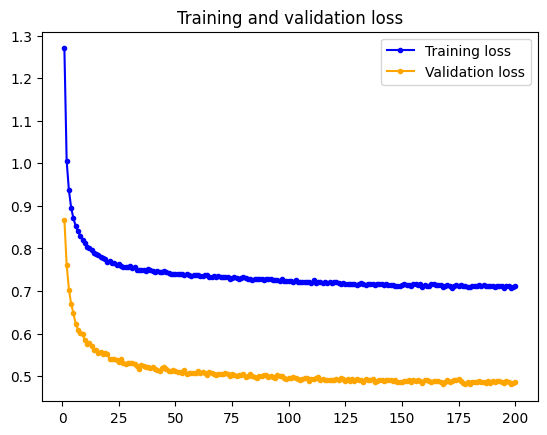

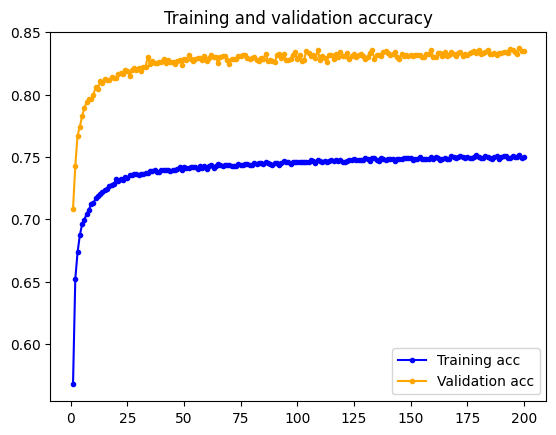

In [32]:
### Plot training and validation accuracy and loss over time

# Extract accuracy and loss values (in list form) from the history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a list of epoch numbers
epochs = range(1, len(acc) + 1)

# Plot training and validation loss values over time
plt.figure()
plt.plot(epochs, loss, color='blue', marker='.', label='Training loss')
plt.plot(epochs, val_loss, color='orange', marker='.', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Plot training and validation accuracies over time
plt.figure()
plt.plot(epochs, acc, color='blue', marker='.', label='Training acc')
plt.plot(epochs, val_acc, color='orange', marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [33]:
### Create confusion matrix from validation set

# Find predictions from all validation samples
y_pred = model.predict(X_val)
print("Validation output shape:", y_pred.shape)

# Convert actual and predicted validation one-hot encoding to numerical labels
y_val_trans = np.argmax(y_val, axis=1)
y_pred_trans = np.argmax(y_pred, axis=1)

# Print some values from actual and predicted validation sets (first 50 samples)
print("Actual validation labels:\t", y_val_trans[:50])
print("Predicted validation labels:\t", y_pred_trans[:50])

# Compute confusion matrix (note: we need to transpose SKLearn matrix to make it match Edge Impulse)
cm = confusion_matrix(y_val_trans, y_pred_trans)
cm = np.transpose(cm)

labels = range(len(gdf['uso_suelo'].unique()))

# Print confusion matrix
print()
print(" ---> Predicted labels")
print("|")
print("v Actual labels")
print("\t\t\t" + ' '.join("{!s:6}".format('(' + str(i) + ')') for i in range(num_classes)))
for row in range(num_classes):
  print("{:>12} ({}):  [{}]".format(labels[row], row, ' '.join("{:6}".format(i) for i in cm[row])))
    

1465/1465 ━━━━━━━━━━━━━━━━━━━━ 1s 336us/step
Validation output shape: (46865, 11)
Actual validation labels:	 [ 2 10  1  9  9  9  6  0  7  1 10  8 10  4  1  8  2  0  5  0  3  5  1  9
  5  4  8 10  9  4  1  7  5  5  5  2  4  9  5  2  3  6  2  5 10  9  7  1
  1  0]
Predicted validation labels:	 [ 8  1  4  9  2  9  6  0  7  1 10  8 10  4  3  8  6  0  6  0  3  1  1  9
  2  4  8 10  9  4  1  7  5  5  5  2  4  5  5  2  8  6  2  5 10  8  7  5
  1  0]

 ---> Predicted labels
|
v Actual labels
			(0)    (1)    (2)    (3)    (4)    (5)    (6)    (7)    (8)    (9)    (10)  
           0 (0):  [  4277     10     15      0      2      8      7      0      8     18      0]
           1 (1):  [     0   2671     17      9    256    436      1      0      0     34     55]
           2 (2):  [     0    128   3428     90     26    212     26      0     32    576     53]
           3 (3):  [     0    129    104   3903     72    272     10      0      2    245     18]
           4 (4):  [     0    231     1

Predict landuse for every element

In [35]:
y_hat = model.predict(X)

1159/1159 ━━━━━━━━━━━━━━━━━━━━ 1s 572us/step


2025-07-17 12:46:18.346836: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 8 bytes spill stores, 8 bytes spill loads



Assign data to polygons

In [36]:
gdf['pred'] = y_hat.argmax(axis=1)

### Save output

In [37]:
gdf.to_file('../../data/processed/prediccion_uso_suelo/test/tess_pca_pred.gpkg')